# Project 2: Predicting Ames, IA housing prices

**NB:** This is my 2nd notebook. See `project-2_JQ.ipynb` for reference to original EDA and first model(s) efforts or supplemental reference. So far best Kaggle submission is based of RidgeCV model (as submission3) in that notebook.

## 1. Define Question
**Question:** Can we predict housing prices in Ames, IA to make sure I'm not underselling my house given its features?

## 2. Get Data

In [1117]:
### IMPORT FEST!!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn.metrics as metrics

%matplotlib inline

In [1118]:
## Here are a couple Python files I wrote with some handy functions for EDA/cleaning and plotting
## See help(notebook_starter) and help(plotter) for more info.
from notebook_starter import *
import notebook_starter

from plotter import *
import plotter

In [1119]:
#Let's read in the data!
train = pd.read_csv('./train.csv')
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [1120]:
train.shape

(2051, 81)

In [1121]:
# train.info()

In [1122]:
## per Adam, TTS-ing before I do anything else, now that I have my data!
from sklearn.cross_validation import train_test_split
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=19)

## 3. Explore data

In [1123]:
## putting target variable back together on feature set for full exploratory dataset. 
## we will end up doing the same cleaning step
eda = pd.concat([X_train,y_train], axis=1)
eda.head(3)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1611,879,907290210,120,RM,NaN,4435,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,5,2009,WD,140000
754,645,535304100,20,RL,67.0,13070,Pave,NaN,Reg,Lvl,...,255,0,NaN,NaN,NaN,0,10,2009,WD,126000
1948,2891,914476500,90,RL,82.0,11070,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,7,2006,WD,171000


In [1124]:
eda.shape

(1538, 81)

### CLEANER FUNCTION:
- Below, I'm going to keep adding steps to this as I clean this dataset, so I can run the same on test data.

In [1125]:
# def null_filler(df):
#     lotfill = df.loc[df[df['Lot Frontage'].isnull()].index, 'Lot Shape'].map(df.groupby('Lot Shape').agg('mean')['Lot Frontage'])

#     df.loc[:,'Lot Frontage'] = df.loc[:,'Lot Frontage'].fillna(lotfill)
    
#     df = df.fillna(df.mean())

In [1126]:
# def column_dropper1(df):
#     df = df.drop(['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu'], axis=1)

In [1127]:
# def column_dropper2(df):
#     drop_cols = ['Id', 'PID', 'MS SubClass', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Mo Sold', 'Yr Sold', 'Overall Qual', 'Overall Cond']
#     df = df.loc[:,numeric_cols].drop(drop_cols, axis=1, inplace=True)   

In [1128]:
## looks for null values, then returns the columns + #nullvals in descending order
null_checker(eda) / eda.shape[0]

Pool QC           0.996099
Misc Feature      0.971391
Alley             0.934330
Fence             0.812094
Fireplace Qu      0.490897
Lot Frontage      0.163199
Garage Yr Blt     0.057867
Garage Cond       0.057867
Garage Qual       0.057867
Garage Finish     0.057867
Garage Type       0.057217
Bsmt Exposure     0.025358
BsmtFin Type 2    0.024707
Bsmt Cond         0.024057
Bsmt Qual         0.024057
BsmtFin Type 1    0.024057
Mas Vnr Type      0.010403
Mas Vnr Area      0.010403
Bsmt Half Bath    0.001300
Bsmt Full Bath    0.001300
Garage Cars       0.000650
BsmtFin SF 1      0.000650
BsmtFin SF 2      0.000650
Bsmt Unf SF       0.000650
Garage Area       0.000650
Total Bsmt SF     0.000650
dtype: float64

In [1129]:
## dropping the first 5 features b/c they just have too many nulls to be worthwhile.
eda = eda.drop(['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu'], axis=1)

In [1130]:
eda.shape

(1538, 76)

In [1131]:
## next I'm going to check out the numeric columns and see if I can't just build a simple linear regression to start
numeric_cols = []
for i in range(len(train.dtypes)):
    if train.dtypes[i] !=object:
        numeric_cols.append(train.columns[i])
                             
numeric_cols = numeric_cols[:-1]
numeric_cols

['Id',
 'PID',
 'MS SubClass',
 'Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold']

**A few notes...**
- Id, PID, and Sale Price (eventually, after looking at correlations) are going to be dropped for sure, since they're either not relevant or the actual target variable. 
- MS SubClass, Year Built, Year Remod/Add, Garage Yr Blt, Mo Sold, Yr Sold, Overall Qual and Overall Cond are all #s, but technically categorical. So we're gonna drop them for this exercise.

In [1132]:
drop_cols = ['Id', 'PID', 'MS SubClass', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Mo Sold', 'Yr Sold', 'Overall Qual', 'Overall Cond']
eda = eda[numeric_cols].drop(drop_cols, axis=1)

In [1133]:
eda['SalePrice'] = train['SalePrice']

In [1134]:
eda.shape

(1538, 29)

In [1135]:
eda.head()

,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,...,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice
1611,NaN,4435,170.0,685.0,0.0,163.0,848.0,848,0,0,...,2.0,420.0,140,0,0,0,0,0,0,140000
754,67.0,13070,0.0,308.0,0.0,323.0,631.0,1112,0,0,...,2.0,480.0,0,0,0,0,255,0,0,126000
1948,82.0,11070,70.0,0.0,0.0,1907.0,1907.0,1959,0,0,...,3.0,766.0,0,0,0,0,0,0,0,171000
22,103.0,12867,NaN,0.0,0.0,1209.0,1209.0,1209,1044,0,...,2.0,575.0,243,142,0,0,0,0,0,344133
1202,64.0,8333,0.0,0.0,0.0,738.0,738.0,738,753,0,...,2.0,484.0,100,30,0,0,0,0,0,168675


**Notes:** Great, now we're down to 29 columns and can look at some correlations perhaps.

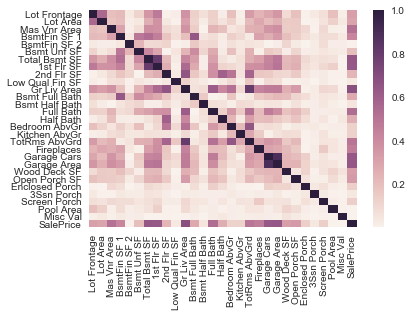

In [1136]:
sns.heatmap(abs(eda.corr()));

looks like there's a couple strong collinear features, but hopefully we'll get our automatic selection to drop them.

In [1137]:
## looking at specifically how correlated each feature is to our target, SalePrice
abs(eda.corr()['SalePrice']).sort_values(ascending=False)[1:]

Gr Liv Area        0.693945
Total Bsmt SF      0.643637
Garage Area        0.641826
Garage Cars        0.640536
1st Flr SF         0.638575
Full Bath          0.536312
Mas Vnr Area       0.518867
TotRms AbvGrd      0.497535
Fireplaces         0.464189
BsmtFin SF 1       0.424019
Open Porch SF      0.340122
Wood Deck SF       0.325097
Lot Frontage       0.320956
Lot Area           0.301625
Bsmt Full Bath     0.284181
Half Bath          0.262149
2nd Flr SF         0.236224
Bsmt Unf SF        0.200331
Screen Porch       0.136656
Enclosed Porch     0.136327
Kitchen AbvGr      0.128003
Bedroom AbvGr      0.126641
Bsmt Half Bath     0.048744
3Ssn Porch         0.036718
Low Qual Fin SF    0.033130
BsmtFin SF 2       0.004883
Pool Area          0.003233
Misc Val           0.000410
Name: SalePrice, dtype: float64

In [1138]:
## now seeing of the columns I have left, what null vals there are. 
null_checker(eda)

Lot Frontage      251
Mas Vnr Area       16
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Area         1
Garage Cars         1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
dtype: int64

** Imputing Nulls **

For the columns with samll # of nulls (all but 'Lot Frontage'), I'll just use the mean. But I think we can be a little bit smarter than that for the lot column, by filling off of the 'Lot Shape' which probably helps.

C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


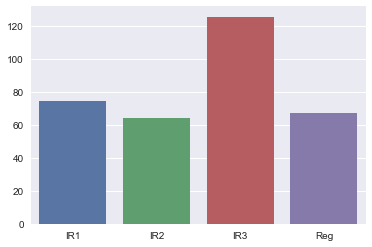

In [1139]:
# plotting the mean lot frontage by lot shape
plot_groupby(X_train, 'Lot Frontage', 'Lot Shape');

In [1140]:
## finding the index of the null locations, and mapping for each of those, the mean of lot shape into the position.

lotfill = X_train.loc[X_train[X_train['Lot Frontage'].isnull()].index, 'Lot Shape'].map(X_train.groupby('Lot Shape').agg('mean')['Lot Frontage'])

eda['Lot Frontage'].fillna(lotfill, inplace=True)

## now filling every other NaN value with just the column mean:
eda.fillna(eda.mean(), inplace=True)

In [1141]:
## let's check to make sure there are no nulls now!!
null_checker(eda)

Series([], dtype: float64)

## 4. Model your data! ... and 5. Evaluate your model(s)

### Let's try a simple linear regression first.

In [1142]:
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**Next Steps:**
- Clean test data.
- Fit train data.
- Score test data.
- Tune as necessary.

**Cleaning.**

In [1143]:
lotfill = X_test.loc[X_test[X_test['Lot Frontage'].isnull()].index, 'Lot Shape'].map(X_test.groupby('Lot Shape').agg('mean')['Lot Frontage'])

X_test.loc[:,'Lot Frontage'] = X_test.loc[:,'Lot Frontage'].fillna(lotfill)

## now filling every other NaN value with just the column mean:
X_test = X_test.fillna(X_test.mean())

C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


**Let's make our new feature sets**

In [1144]:
X_test_slr = X_test.loc[:,numeric_cols]
X_test_slr = X_test_slr.drop(drop_cols, axis=1)

# X_test = X_test.loc[:,numeric_cols]
# X_test = X_test.drop(drop_cols, axis=1)


# X_train = eda.drop(['SalePrice'], axis=1)

X_train_slr = eda.drop(['SalePrice'], axis=1)

In [1145]:
X_test_slr.shape, X_train_slr.shape

((513, 28), (1538, 28))

In [1146]:
null_checker(X_test_slr)

Series([], dtype: float64)

**Fitting.**

In [1147]:
X_test_slr.columns == eda.columns[:-1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [1148]:
ss = StandardScaler()
ss.fit(X_train_slr)
X_train_slr = ss.transform(X_train_slr)
X_test_slr = ss.transform(X_test_slr)

In [1149]:
lr = LinearRegression()
lr.fit(X_train_slr, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1150]:
print(cross_val_score(LinearRegression(), X_test_slr, y_test))
print(cross_val_score(LinearRegression(), X_test_slr, y_test).mean())

[0.74192798 0.48514499 0.79884627]
0.6753064166085103


In [1151]:
np.argmin(lr.coef_), np.argmax(lr.coef_)

(8, 10)

In [1152]:
eda.columns[8], eda.columns[10]

('2nd Flr SF', 'Gr Liv Area')

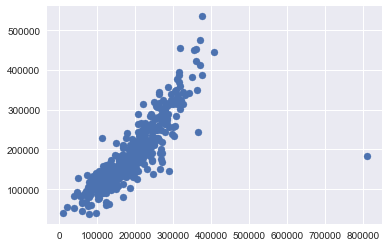

In [1153]:
plt.scatter(lr.predict(X_test_slr), y_test);

In [1154]:
checkdata.head()

,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,...,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,yhat
0,0.091831,-0.193154,-0.570721,0.576625,-0.298088,-0.777443,-0.295180,-0.607647,0.832637,-0.117471,...,0.288931,-0.019967,-0.725680,-0.162429,-0.377887,-0.101152,-0.287733,-0.06125,-0.09268,188382.637707
1,-0.223257,-0.183049,-0.570721,0.118538,-0.298088,-0.161396,-0.150920,-0.441317,-0.759168,-0.117471,...,-1.021060,-0.807217,-0.725680,0.255673,-0.377887,-0.101152,-0.287733,-0.06125,-0.09268,100949.812180
2,0.245532,0.069577,-0.570721,-0.956121,-0.298088,-0.076269,-1.181027,-0.074873,0.752812,-0.117471,...,0.288931,0.026071,-0.725680,1.868351,-0.377887,-0.101152,-0.287733,-0.06125,-0.09268,183863.592390
3,0.001806,-0.323136,-0.570721,0.138077,0.352179,-0.555666,-0.283909,0.320159,-0.759168,-0.117471,...,0.288931,0.145770,-0.725680,-0.699988,-0.377887,-0.101152,-0.287733,-0.06125,-0.09268,150071.637759
4,-0.199100,-0.896495,-0.152976,1.397274,-0.298088,-0.548946,0.786771,1.115422,-0.759168,-0.117471,...,1.598922,0.716642,0.376275,-0.401344,-0.377887,-0.101152,-0.287733,-0.06125,-0.09268,259601.000915


In [1155]:
X_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
1371,993,527105050,60,RL,72.000000,8702,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2008,WD
672,2121,907125120,20,RL,65.000000,8775,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2007,WD
764,123,534403360,80,RL,75.414634,10600,Pave,Pave,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,5,2010,COD
932,1237,535151160,20,RL,70.000000,7763,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,10,2008,WD
504,1744,528228375,120,RL,65.536667,3621,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,11,2007,WD


In [1156]:
checkdata = pd.DataFrame(data=X_test_slr, columns=eda.columns[:-1])
checkdata['yhat'] = lr.predict(X_test_slr)
# checkdata.sort_values(by='yhat', ascending=False)

In [1157]:
checkdata[checkdata['yhat'] > 800000]

,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,...,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,yhat
315,2.612532,4.041008,6.530948,7.749704,-0.298088,1.160306,9.102016,10.227153,-0.759168,-0.117471,...,1.598922,3.129035,3.481786,6.527198,-0.377887,-0.101152,-0.287733,-0.06125,39.483658,810870.983359


** Checking to see if the values on the weird outlier have super high/low values for the strongest associated betas**

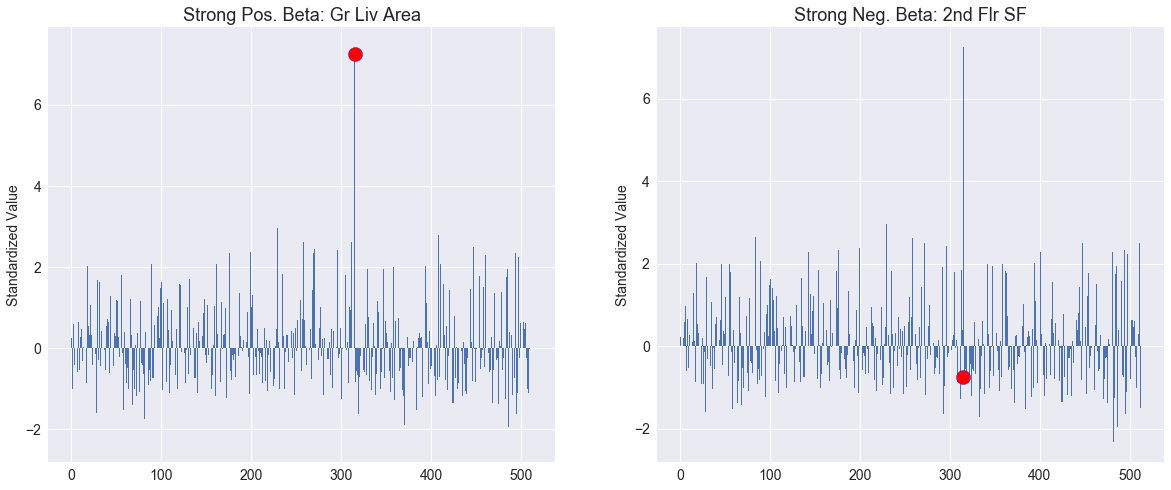

In [1158]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 8));

ax[0].bar(checkdata.index, checkdata['Gr Liv Area']);
ax[0].scatter(315,checkdata.loc[315, 'Gr Liv Area'], color='r', s=200, edgecolors='b', zorder=5);
ax[0].set_title('Strong Pos. Beta: Gr Liv Area', fontsize=18);


ax[1].bar(checkdata.index, checkdata['Gr Liv Area']);
ax[1].scatter(315,checkdata.loc[315, '2nd Flr SF'], color='r', s=200, edgecolors='b', zorder=10);
ax[1].set_title('Strong Neg. Beta: 2nd Flr SF', fontsize=18);

ax[0].set_ylabel('Standardized Value', fontsize=14);
ax[1].set_ylabel('Standardized Value', fontsize=14);

ax[0].tick_params(axis='both', labelsize =14);
ax[1].tick_params(axis='both', labelsize =14);

** Okay. So we have a strong outlier for our largest pos. beta.**

the predicted price, ~800,000, and the actual price, 87,550, seem off by about an order of mag

In [1159]:
train.loc[315, 'SalePrice']

87550

In [1160]:
checkdata.loc[315, 'yhat']

810870.9833590338

In [1161]:
y_train[315]

87550

### RidgeCV

In [1162]:
## defining a baseline and some plots to be able to look at my optimized alpha value nicely

lr_cv_mean_mse = -cross_val_score(lr, 
                                 X_train_slr,
                                 y_train,
                                 cv=5,
                                 scoring='neg_mean_squared_error').mean()

def plot_cv(alphas, cv_means, optimal_alpha, lr_mse, log=False):
    # alphas = list of alphas
    # cv_means = list of CV mean MSE
    # optimal_alpha
    # lr_mse
    fig = plt.figure(figsize=(12,8))
    ax = plt.gca()

    if log:
        ax.semilogx(alphas, cv_means, lw=2)
    else:
        ax.plot(alphas, cv_means, lw=2)
    ax.axvline(optimal_alpha)
    ax.axhline(lr_mse)
    ax.set_xlabel('alpha')
    ax.set_ylabel('Mean Squared Error')

In [1163]:
## finding optimal alpha and fitting ridge model

r_alphas = np.logspace(0, 20, 200)
# r_alphas = np.

ridge_model = RidgeCV(alphas = r_alphas, store_cv_values=True)
ridge_model = ridge_model.fit(X_train_slr, y_train)

ridge_optimal_alpha = ridge_model.alpha_

ridge_cv_means = [np.mean(cv_alpha) for cv_alpha in ridge_model.cv_values_.T]

ridge_optimal_alpha, np.mean(ridge_cv_means)

(410.26581058271944, 5377570318.1528845)

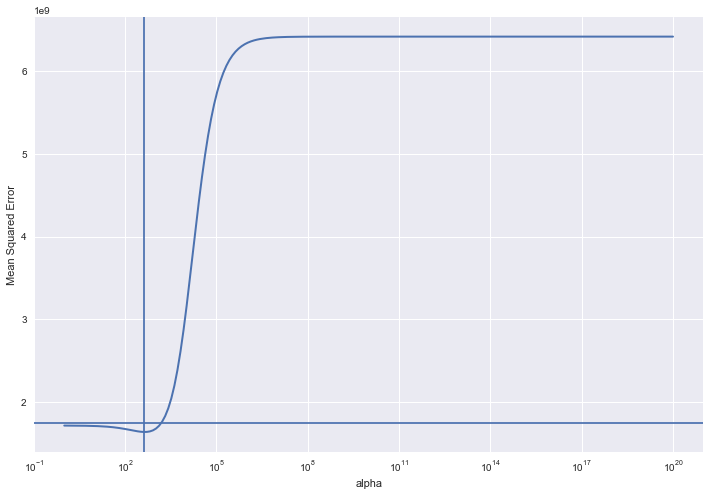

In [1164]:
plot_cv(ridge_model.alphas, ridge_cv_means, ridge_optimal_alpha, lr_cv_mean_mse, log=True)

In [1165]:
## let's check this against data it's never seen.

ridge_model.score(X_train_slr, y_train), ridge_model.score(X_test_slr, y_test)

(0.7736136223274894, 0.6970173465417704)

In [1166]:
# plt.scatter(y_test, ridge_model.predict(X_test_slr));

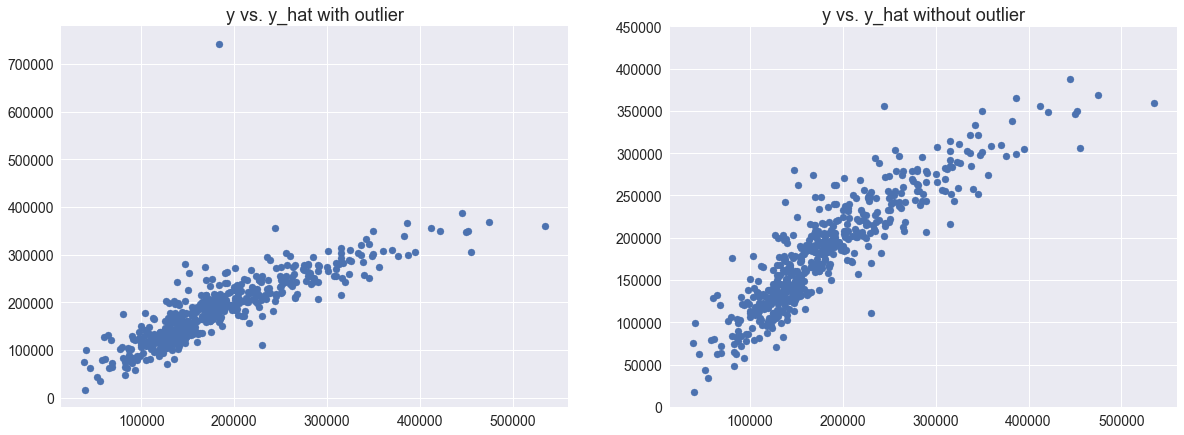

In [1167]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 7));

ax[0].scatter(y_test, ridge_model.predict(X_test_slr));
ax[0].set_title('y vs. y_hat with outlier', fontsize=18);

ax[1].scatter(y_test, ridge_model.predict(X_test_slr));
ax[1].set_ylim(0, 450000);
ax[1].set_title('y vs. y_hat without outlier', fontsize=18);

ax[0].tick_params(axis='both', labelsize =14);
ax[1].tick_params(axis='both', labelsize = 14);

**Takeaways:** hmm... something funky happened.

### LassoCV

In [1168]:
# l_alphas = np.arange(0.001, 0.15, 0.0025)

lasso_model = LassoCV()
lasso_model = lasso_model.fit(X_train_slr, y_train)

lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

lasso_cv_means = [np.mean(cv_alpha) for cv_alpha in lasso_model.mse_path_]

lasso_cv_rsme = np.sqrt(np.mean(lasso_cv_means))
print(lasso_cv_rsme)

lasso_model.score(X_train_slr, y_train), lasso_model.score(X_test_slr, y_test)

46620.89192517357


(0.7746897437374144, 0.6968826995212365)

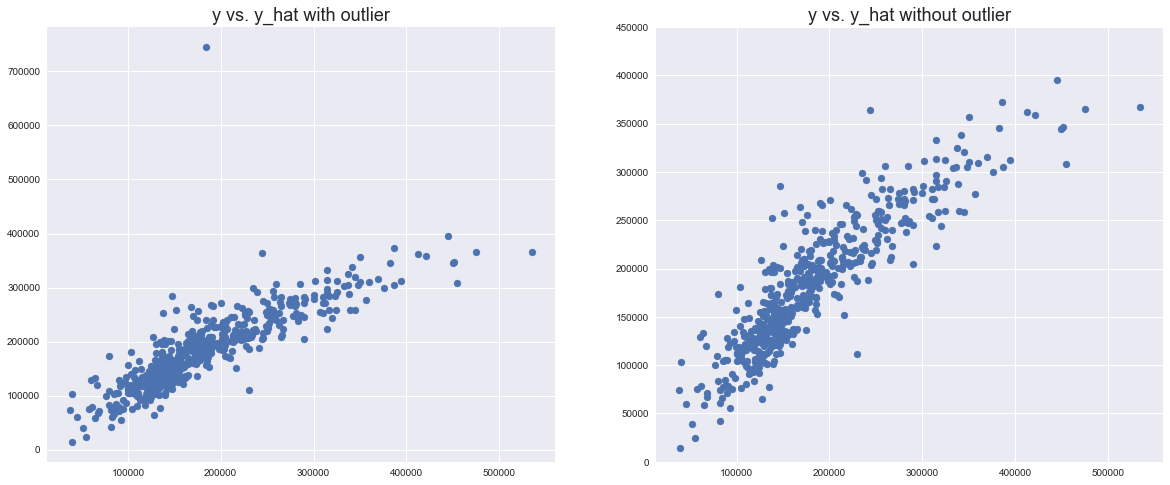

In [1169]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 8));

ax[0].scatter(y_test, lasso_model.predict(X_test_slr));
ax[0].set_title('y vs. y_hat with outlier', fontsize=18);

ax[1].scatter(y_test, lasso_model.predict(X_test_slr));
ax[1].set_ylim(0, 450000);
ax[1].set_title('y vs. y_hat without outlier', fontsize=18);

In [1170]:
print(np.sqrt(np.mean(ridge_cv_means)) > np.sqrt(np.mean(lasso_cv_means)))
print(np.sqrt(np.mean(lasso_cv_means)) > np.sqrt(np.mean(elastic_cv_means)))

True
False


** Okay, let's see how this Lasso model actually did.**

In [1171]:
test = pd.read_csv('./test.csv')

In [1172]:
lotfill = test.loc[test[test['Lot Frontage'].isnull()].index, 'Lot Shape'].map(test.groupby('Lot Shape').agg('mean')['Lot Frontage'])

test.loc[:,'Lot Frontage'] = test.loc[:,'Lot Frontage'].fillna(lotfill)

## now filling every other NaN value with just the column mean:
test = test.fillna(test.mean())


X_test_test = test.loc[:,numeric_cols]
X_test_test = X_test_test.drop(drop_cols, axis=1)

In [1173]:
X_test_test.shape

(879, 28)

**re-running the model to fit on all of our data so that we can fit it extra nice for the test data**

In [1174]:
yhat = lasso_model.predict(X_test_test)

In [1175]:
submission4 = pd.DataFrame(data=yhat, columns=['SalePrice'], index=test['Id'])

SalePrice    1.881706e+07
dtype: float64


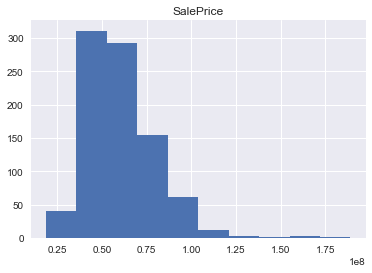

In [1176]:
print(submission4.min())
submission4.hist();

In [1177]:
## commenting out so it doesn't re-save when you run it :P
# submission4.to_csv('./Submissions/project2submit_jq04_05.17.18.csv')

### ElasticNet??

In [1178]:
l1_ratios = np.linspace(0.05, 1, 19)

elastic_model = ElasticNetCV(l1_ratio=l1_ratios, cv=5, n_alphas=100)
elastic_model = elastic_model.fit(X_train_slr, y_train)

elastic_optimal_alpha = elastic_model.alpha_
elastic_cv_means = [np.mean(cv_alpha) for cv_alpha in elastic_model.mse_path_]


print('Optimal alpha:',elastic_optimal_alpha)
print('Optimal l1 ratio:',elastic_model.l1_ratio_)
print('Min. RMSE:', np.sqrt(np.mean(elastic_cv_means)))
print('Train score:',elastic_model.score(X_train_slr, y_train))
print('Test score:',elastic_model.score(X_test_slr, y_test))

Optimal alpha: 1581.9905796129767
Optimal l1 ratio: 1.0
Min. RMSE: 77190.63681379844
Train score: 0.7740193753991655
Test score: 0.6971113370461124


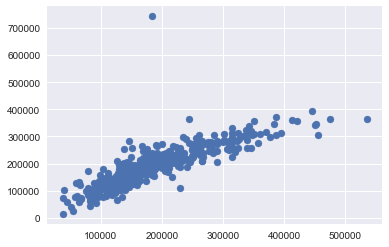

In [1179]:
plt.scatter(y_test, elastic_model.predict(X_test_slr));

These scores are still not very good and the scatter plot (actual y vs. predicted y) on this looks worse than the others. Time to abandon ship and try a new direction.

### Okay, going to try that LR one more time, but with PolyFeatures

Let's see if some of these interaction terms help.

In [1180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [1181]:
X_test_pff = X_test.loc[:,numeric_cols]
X_test_pff = X_test_pff.drop(drop_cols, axis=1)
X_train_pff = eda.drop(['SalePrice'], axis=1)


ss = StandardScaler()
pf = PolynomialFeatures(interaction_only=False, include_bias=False)
ridge = RidgeCV()

pipey = Pipeline([
    ('ss', ss),
    ('pf', pf),
    ('ridge',ridge)
])

In [1182]:
pipey.fit(X_train_pff, y_train)

Pipeline(memory=None,
     steps=[('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pf', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('ridge', RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False))])

In [1183]:
pipey.score(X_train_pff, y_train)

0.9266096026405246

- whoa, really good!

In [1184]:
pipey.score(X_test_pff, y_test)

0.5671859802889357

- boooo, massively overfit :(

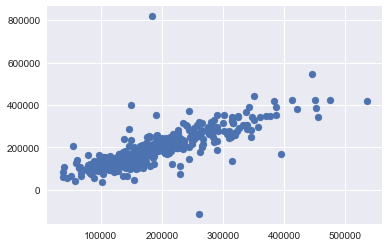

In [1185]:
plt.scatter(y_test, pipey.predict(X_test_pff));

In [1186]:
from sklearn.feature_selection import RFE, RFECV

In [1187]:
lr = LinearRegression()
rfecv = RFECV(lr, cv=10)
rfecv.fit(X_train_slr, y_train)

RFECV(cv=10,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [1188]:
rfecv.support_.sum()

22

In [1189]:
rfecv.score(X_test_slr, y_test)

0.6871978486826082

In [1190]:
check = eda.iloc[:,:-1]
ftcols = pd.DataFrame(list(zip(check.columns, rfecv.support_)))

In [1191]:
ftcols

,0,1
0,Lot Frontage,False
1,Lot Area,False
2,Mas Vnr Area,True
3,BsmtFin SF 1,True
4,BsmtFin SF 2,False
5,Bsmt Unf SF,True
6,Total Bsmt SF,True
7,1st Flr SF,True
8,2nd Flr SF,True
9,Low Qual Fin SF,True


In [1192]:
rfe = RFE(LinearRegression())
rfe.fit(X_train_slr, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  n_features_to_select=None, step=1, verbose=0)

In [1193]:
rfe.score(X_test_slr, y_test)

0.6790947980839777

In [1194]:
rfe.support_.sum()

14

In [1195]:
rfecols = pd.DataFrame(list(zip(check.columns, rfe.support_, rfe.ranking_)), columns=['feature','include','rank'])
rfecols

,feature,include,rank
0,Lot Frontage,False,10
1,Lot Area,False,11
2,Mas Vnr Area,True,1
3,BsmtFin SF 1,True,1
4,BsmtFin SF 2,False,13
5,Bsmt Unf SF,False,2
6,Total Bsmt SF,True,1
7,1st Flr SF,True,1
8,2nd Flr SF,True,1
9,Low Qual Fin SF,False,9


In [1196]:
## trying something weird?
rfer = RFE(RidgeCV())
rfer.fit(X_train_slr, y_train)

RFE(estimator=RidgeCV(alphas=(0.1, 1.0, 10.0), cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False),
  n_features_to_select=None, step=1, verbose=0)

In [1197]:
rfer.score(X_test_slr, y_test)

0.6794643067527392

** Trying again, but with only highly correlated cols **

In [1198]:
corr = abs(eda.corr()['SalePrice']).sort_values(ascending=False)[1:]

In [1199]:
newcols = [corr.index[i] for i,_ in enumerate(corr) if _ > 0.5]

In [1200]:
Xtr_new = eda[newcols]
Xte_new = X_test[newcols]

In [1201]:
ss = StandardScaler()
Xtr_new = ss.fit_transform(Xtr_new)
Xte_new = ss.transform(Xte_new)

In [1202]:
lr = LinearRegression()
lr.fit(Xtr_new, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1203]:
cross_val_score(lr, Xte_new, y_test).mean()

0.6233116497519148

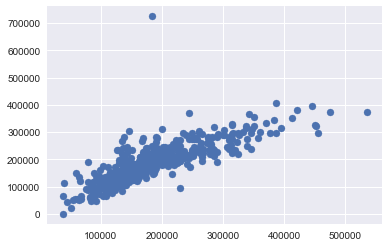

In [1204]:
plt.scatter(y_test, lr.predict(Xte_new));

0.6021465636038267


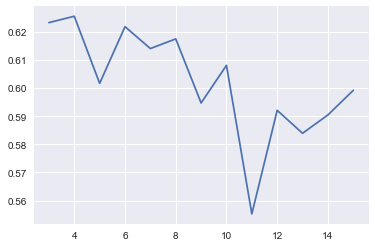

In [1205]:
xs = []
ys = []
for i in range(3,16):
    xs.append(i)
    ys.append(cross_val_score(lr, Xte_new, y_test, cv=i).mean())
    
    
plt.plot(xs, ys);
print(np.mean(ys))

** next try with Ridge**

In [1206]:
r_alphas = np.logspace(0, 20, 200)

## build a Ridge model with cross-validation to search for best alpha within range given
ridge_model = RidgeCV(alphas = r_alphas, store_cv_values=True)
ridge_model = ridge_model.fit(Xtr_new, y_train)

ridge_optimal_alpha = ridge_model.alpha_

ridge_cv_means = [np.mean(cv_alpha) for cv_alpha in ridge_model.cv_values_.T]

ridge_optimal_alpha, np.mean(ridge_cv_means)

(162.5755666443795, 5463171277.024735)

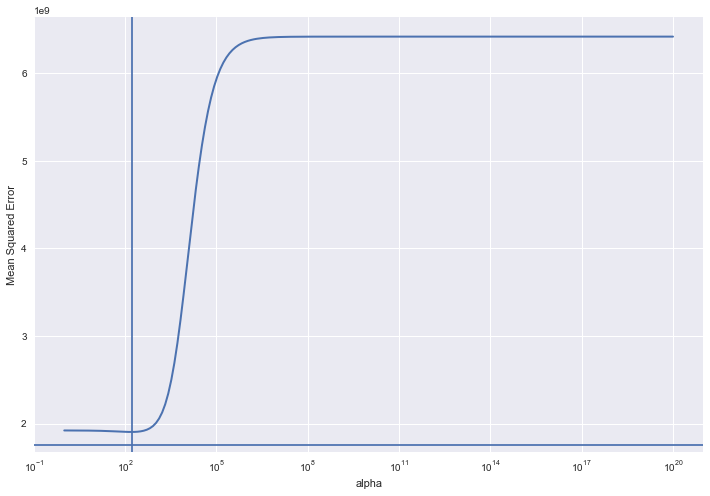

In [1207]:
plot_cv(ridge_model.alphas, ridge_cv_means, ridge_optimal_alpha, lr_cv_mean_mse, log=True)

In [1208]:
ridge_model.score(Xtr_new, y_train), ridge_model.score(Xte_new, y_test)

(0.7164815651594408, 0.647622189395852)

### Trying some work with Pipeline + Poly + GridSearchCV

In [1209]:
from sklearn.model_selection import GridSearchCV

In [1210]:
test = pd.read_csv('./test.csv')

In [1211]:
mega = pd.concat([train, test])

In [1212]:
train.tail()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
2046,1587,921126030,20,RL,79.0,11449,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,1,2008,WD,298751
2047,785,905377130,30,RL,NaN,12342,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2009,WD,82500
2048,916,909253010,50,RL,57.0,7558,Pave,NaN,Reg,Bnk,...,0,0,NaN,NaN,NaN,0,3,2009,WD,177000
2049,639,535179160,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,11,2009,WD,144000
2050,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,6,2010,WD,189000


In [1213]:
features = ['Neighborhood', 'House Style', 'Lot Config']
dummies = mega[features]

dummies = pd.get_dummies(dummies, columns=features, drop_first=True)

In [1214]:
mega2 = pd.concat([mega['Lot Area'], dummies], axis=1)

train2 = mega2.iloc[:len(train)]
test2 = mega2.iloc[len(train):]

train2.shape, test2.shape

((2051, 39), (879, 39))

In [1215]:
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(train2, y, random_state=64)

In [1216]:
X_train.shape, X_test.shape

((1538, 39), (513, 39))

In [1217]:
ss = StandardScaler()
pf = PolynomialFeatures(include_bias=False)
lasso = LassoCV()

In [1218]:
pipe_pf = Pipeline([
    ('ss',ss),
    ('pf', pf),
    ('lasso',lasso)
])

In [1219]:
params_pf = {
    'pf__interaction_only':['True','False'],
}

gs_pf = GridSearchCV(pipe_pf, param_grid=params_pf)
gs_pf.fit(X_train, y_train)

print(gs_pf.best_score_)
print(gs_pf.best_params_)

C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did no

0.6235358527739071
{'pf__interaction_only': 'True'}


In [1220]:
gs_pf.score(X_test, y_test)

0.6434759274512923

## New tactic: Pools... and when it's hot.

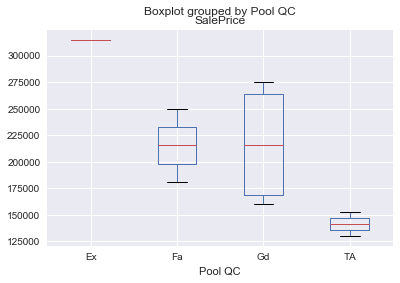

In [1221]:
train.boxplot(column='SalePrice', by='Pool QC');

In [1222]:
pools = train.copy()
pools['Pool QC'] = pools['Pool QC'].fillna('NA')

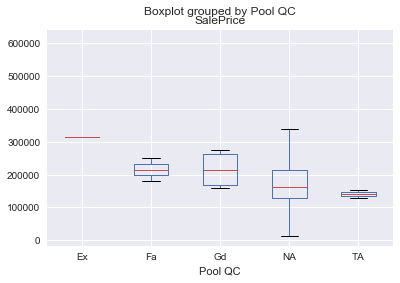

In [1223]:
pools.boxplot(column='SalePrice', by='Pool QC');

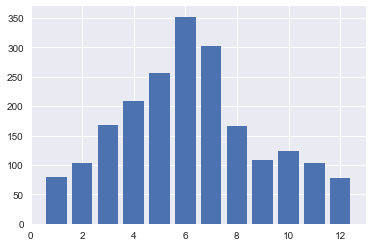

In [1224]:
plt.bar(x=pools['Mo Sold'].value_counts().sort_index().index, height=pools['Mo Sold'].value_counts().sort_index());

In [1225]:
summer = [5, 6, 7, 8]
pools['summer'] = pools['Mo Sold'].map(lambda x: int(1) if x in summer else int(0))

In [1226]:
newnew = pd.concat([pools, test])

In [1227]:
newnew.shape

(2930, 82)

In [1228]:
poolsdums = pd.get_dummies(newnew['Neighborhood'], prefix='nbhd', drop_first=True)

In [1229]:
middle = pd.concat([newnew['summer'], poolsdums], axis=1)

pools2 = middle.iloc[:len(pools)]
test2 = middle.iloc[len(pools):]

pools2.shape, test2.shape

((2051, 28), (879, 28))

In [1230]:
# pools2['summer'] = pools2.summer.astype(int)

In [1231]:
X = pools2
y = pools['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=64)

In [1232]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5505465352557337

## 6. Answer Question

**Q: Were we able to predict home prices?** 

A: Somewhat. I wasn't really able to tweak the model to a place where I felt very good about the outputs. My R^2 scores were fairly low (70-80% range) compared to what I think I could achieve. That said, I did follow the data science workflow and was able to predict prices within the expected range. I just wouldn't make an investment strategy out of it :)

**Next steps**
1. More feature selection and engineering work.
    - Involve more categorical variables
    - Try polynomial features on more data
    - Use `itertools.combinations` to try more variations of feature combos
2. Use `GridSearchCV` to more exhaustively tune hyper-parameters
3. Try different models!